In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("C:\\Users\\Bram\\Desktop\\New folder\\data\\futures\\um\\daily\\klines\\ETHUSDT\\1m\\2019-12-31_2022-07-28\\ETHUSDTPERP_1m_2019-12-31_2022-07-28.csv", header=None)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Bram\\Desktop\\New folder\\data\\futures\\um\\daily\\klines\\ETHUSDT\\1m\\2019-12-31_2022-07-28\\ETHUSDTPERP_1m_2019-12-31_2022-07-28.csv'

In [4]:
df.info()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1577836800000,129.12,129.12,128.91,128.97,289.040,1.577837e+12,37296.67223,18.0,155.107,20005.44348,0.0
1,1577836860000,128.95,129.04,128.93,128.94,695.566,1.577837e+12,89717.06489,49.0,284.536,36703.77497,0.0
2,1577836920000,128.93,128.97,128.92,128.92,131.902,1.577837e+12,17008.70674,17.0,107.865,13908.75485,0.0
3,1577836980000,128.97,128.98,128.93,128.96,455.572,1.577837e+12,58748.97547,19.0,306.033,39464.28873,0.0
4,1577837040000,128.95,128.95,128.76,128.81,866.117,1.577837e+12,111594.84023,48.0,273.595,35249.08931,0.0


In [5]:
df = df[[4, 6]]
df = df[:-1]
df.tail()

,4,6
1344954,1724.81,1.659053e+12
1344955,1725.44,1.659053e+12
1344956,1724.66,1.659053e+12
1344957,1724.72,1.659053e+12
1344958,1723.82,1.659053e+12


In [6]:
column_names = ["closing_price", "closing_time"]
df.columns = column_names
df.head()

,closing_price,closing_time
0,128.97,1.577837e+12
1,128.94,1.577837e+12
2,128.92,1.577837e+12
3,128.96,1.577837e+12
4,128.81,1.577837e+12


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344959 entries, 0 to 1344958
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   closing_price  1344959 non-null  float64
 1   closing_time   1344959 non-null  float64
dtypes: float64(2)
memory usage: 20.5 MB


In [8]:
df['closing_time'] = pd.to_datetime(df['closing_time'], unit="ms").dt.round(freq='ms')
df.set_index('closing_time', inplace=True)
df = df.sort_index()
df.head()

,closing_price
closing_time,
2020-01-01 00:00:59.999,128.97
2020-01-01 00:01:59.999,128.94
2020-01-01 00:02:59.999,128.92
2020-01-01 00:03:59.999,128.96
2020-01-01 00:04:59.999,128.81


In [9]:
df['50_ma'] = df['closing_price'].rolling(50).mean()
df['200_ma'] = df['closing_price'].rolling(200).mean()
df.tail()

,closing_price,50_ma,200_ma
closing_time,,,
2022-07-28 23:55:59.999,1724.81,1725.5864,1741.98360
2022-07-28 23:56:59.999,1725.44,1725.2306,1741.74635
2022-07-28 23:57:59.999,1724.66,1724.9254,1741.45295
2022-07-28 23:58:59.999,1724.72,1724.6180,1741.17665
2022-07-28 23:59:59.999,1723.82,1724.3232,1740.91955


In [10]:
previous_50 = df['50_ma'].shift(1)
previous_200 = df['200_ma'].shift(1)
down_crossing = ((df['50_ma'] <= df['200_ma']) & (previous_50 >= previous_200))
up_crossing = ((df['50_ma'] >= df['200_ma']) & (previous_50 <= previous_200))
crossings_mask = (((df['50_ma'] >= df['200_ma']) & (previous_50 <= previous_200)) 
             | ((df['50_ma'] <= df['200_ma']) & (previous_50 >= previous_200)))

df['crossing'] = None
df.loc[down_crossing, 'crossing'] = 'down'
df.loc[up_crossing, 'crossing'] = 'up'
crossings = df[crossings_mask]
crossings.head()


,closing_price,50_ma,200_ma,crossing
closing_time,,,,
2020-01-01 04:18:59.999,130.16,130.1926,130.20305,down
2020-01-01 06:11:59.999,130.53,130.2900,130.28660,up
2020-01-01 07:51:59.999,130.09,130.3544,130.35700,down
2020-01-01 09:46:59.999,130.27,130.2370,130.23480,up
2020-01-01 18:37:59.999,131.70,132.1486,132.14905,down


<AxesSubplot:xlabel='closing_time'>

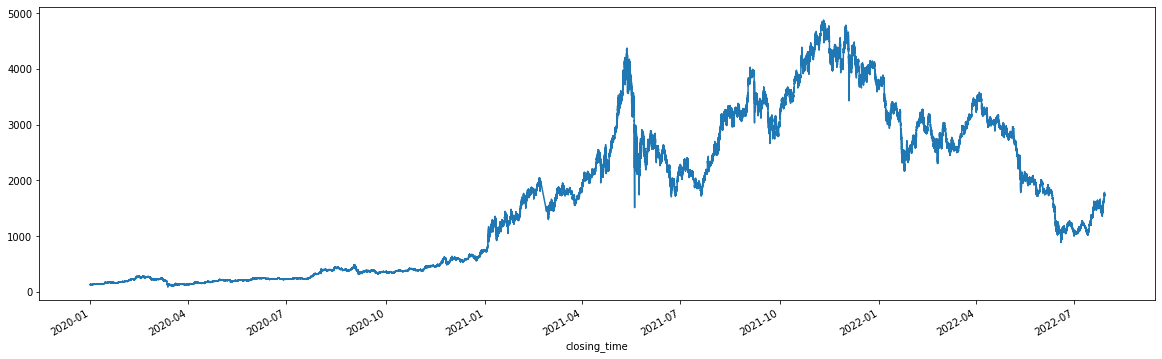

In [11]:
df['closing_price'].plot(figsize=(20,6))


In [12]:
trade_mask = ((crossings['crossing'] == 'up') & (crossings['crossing'].shift(-1) == 'down' ))
entries = crossings[trade_mask]
exit_mask =  ((crossings['crossing'] == 'down') & (crossings['crossing'].shift(1) == 'up' ))
exits = crossings[exit_mask]

In [13]:
tdf = pd.DataFrame({
    'entry_time': entries.index,
    'exit_time': exits.index,
    'entry_price': entries['closing_price'],
    'exit_price': crossings.shift(-1).loc[entries.index, 'closing_price']},
    columns=['entry_time', 'exit_time', 'entry_price', 'exit_price'])
tdf = tdf.set_index('entry_time')

In [14]:
 tdf.head()

,exit_time,entry_price,exit_price
entry_time,,,
2020-01-01 06:11:59.999,2020-01-01 07:51:59.999,130.53,130.09
2020-01-01 09:46:59.999,2020-01-01 18:37:59.999,130.27,131.70
2020-01-01 21:01:59.999,2020-01-01 22:05:59.999,131.96,130.86
2020-01-02 01:06:59.999,2020-01-02 01:57:59.999,130.48,130.22
2020-01-02 04:52:59.999,2020-01-02 07:20:59.999,129.51,129.23


### Profit
(For the profit I assume that we're buying worth our whole account in usd of the asset each trade. We sell only at the close of a candle, our account value is 1k usd in total in the beggining. In the main dataframe the profits, delta_price_trade and account value is at the closing time of the trade.) i want to code this but for now we just buy 1 of the thing, so summing up delta price

In [15]:
tdf['delta_price'] = (tdf['exit_price'] - tdf['entry_price'])*(1 / tdf['entry_price'])
tdf['duration'] = (tdf['exit_time'] - tdf.index)
tdf.head()

,exit_time,entry_price,exit_price,delta_price,duration
entry_time,,,,,
2020-01-01 06:11:59.999,2020-01-01 07:51:59.999,130.53,130.09,-0.003371,0 days 01:40:00
2020-01-01 09:46:59.999,2020-01-01 18:37:59.999,130.27,131.70,0.010977,0 days 08:51:00
2020-01-01 21:01:59.999,2020-01-01 22:05:59.999,131.96,130.86,-0.008336,0 days 01:04:00
2020-01-02 01:06:59.999,2020-01-02 01:57:59.999,130.48,130.22,-0.001993,0 days 00:51:00
2020-01-02 04:52:59.999,2020-01-02 07:20:59.999,129.51,129.23,-0.002162,0 days 02:28:00


In [16]:
tdf['delta_price'].sum(), tdf['duration'].mean(numeric_only=False)

(3.835319230260504, Timedelta('0 days 02:39:03.686098654'))

In [17]:
new_series = [pd.Series([df.iloc[0].name, 0, 0, 0, pd.Timedelta(0)], index=tdf.columns, name=df.iloc[0].name),
             pd.Series([df.iloc[-1].name, 0, 0, 0, pd.Timedelta(0)], index=tdf.columns, name=df.iloc[-1].name)]
tdf = tdf.append(new_series).sort_index()
tdf


C:\Users\Bram\AppData\Local\Temp\ipykernel_17196\3680358118.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tdf = tdf.append(new_series).sort_index()


,exit_time,entry_price,exit_price,delta_price,duration
entry_time,,,,,
2020-01-01 00:00:59.999,2020-01-01 00:00:59.999,0.00,0.00,0.000000,0 days 00:00:00
2020-01-01 06:11:59.999,2020-01-01 07:51:59.999,130.53,130.09,-0.003371,0 days 01:40:00
2020-01-01 09:46:59.999,2020-01-01 18:37:59.999,130.27,131.70,0.010977,0 days 08:51:00
2020-01-01 21:01:59.999,2020-01-01 22:05:59.999,131.96,130.86,-0.008336,0 days 01:04:00
2020-01-02 01:06:59.999,2020-01-02 01:57:59.999,130.48,130.22,-0.001993,0 days 00:51:00
...,...,...,...,...,...
2022-07-28 20:24:59.999,2022-07-28 22:19:59.999,1735.79,1744.33,0.004920,0 days 01:55:00
2022-07-28 22:27:59.999,2022-07-28 22:39:59.999,1748.70,1739.98,-0.004987,0 days 00:12:00
2022-07-28 22:42:59.999,2022-07-28 22:45:59.999,1747.87,1744.51,-0.001922,0 days 00:03:00


In [18]:
account_start = 2228.72

delta_price = tdf['delta_price'].array
account_value = [account_start]
profit = [0]

for i in range(1, len(delta_price)):
    new_p = account_value[i-1] * delta_price[i]
    new_av = new_p + account_value[i-1]
    account_value.append(new_av)
    profit.append(new_p)

In [19]:
tdf['profit'] = profit
tdf['account_value'] = account_value

In [20]:
tdf.head()

,exit_time,entry_price,exit_price,delta_price,duration,profit,account_value
entry_time,,,,,,,
2020-01-01 00:00:59.999,2020-01-01 00:00:59.999,0.00,0.00,0.000000,0 days 00:00:00,0.000000,2228.720000
2020-01-01 06:11:59.999,2020-01-01 07:51:59.999,130.53,130.09,-0.003371,0 days 01:40:00,-7.512731,2221.207269
2020-01-01 09:46:59.999,2020-01-01 18:37:59.999,130.27,131.70,0.010977,0 days 08:51:00,24.382639,2245.589908
2020-01-01 21:01:59.999,2020-01-01 22:05:59.999,131.96,130.86,-0.008336,0 days 01:04:00,-18.718922,2226.870986
2020-01-02 01:06:59.999,2020-01-02 01:57:59.999,130.48,130.22,-0.001993,0 days 00:51:00,-4.437358,2222.433628


In [21]:
tdf.tail()

,exit_time,entry_price,exit_price,delta_price,duration,profit,account_value
entry_time,,,,,,,
2022-07-28 20:24:59.999,2022-07-28 22:19:59.999,1735.79,1744.33,0.004920,0 days 01:55:00,292.321727,59707.910725
2022-07-28 22:27:59.999,2022-07-28 22:39:59.999,1748.70,1739.98,-0.004987,0 days 00:12:00,-297.737166,59410.173560
2022-07-28 22:42:59.999,2022-07-28 22:45:59.999,1747.87,1744.51,-0.001922,0 days 00:03:00,-114.206539,59295.967021
2022-07-28 22:58:59.999,2022-07-28 23:13:59.999,1747.68,1734.52,-0.007530,0 days 00:15:00,-446.497600,58849.469420
2022-07-28 23:59:59.999,2022-07-28 23:59:59.999,0.00,0.00,0.000000,0 days 00:00:00,0.000000,58849.469420


In [22]:
tdf.iloc[1:-1].describe()

,entry_price,exit_price,delta_price,duration,profit,account_value
count,4460.000000,4460.000000,4460.000000,4460,4460.000000,4460.000000
mean,1714.345011,1715.223518,0.000860,0 days 02:39:03.686098654,12.695235,29760.754501
std,1376.685294,1376.862007,0.015945,0 days 02:48:27.860177246,556.055419,25094.477440
min,106.220000,107.870000,-0.253583,0 days 00:01:00,-4380.856579,2192.367399
25%,348.837500,348.907500,-0.006225,0 days 01:00:00,-169.904135,6088.928583
50%,1675.830000,1677.360000,-0.002347,0 days 02:07:00,-20.175491,17490.736506
75%,2921.875000,2919.907500,0.003088,0 days 03:40:00,38.103691,57623.671713
max,4820.580000,4830.640000,0.167591,5 days 00:15:00,5703.985061,78376.487571


<AxesSubplot:xlabel='closing_time'>

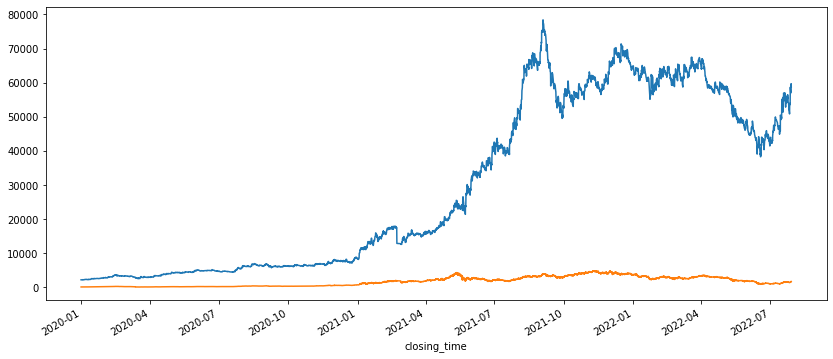

In [23]:
tdf['account_value'].plot(figsize=(14,6))
df['50_ma'].plot(figsize=(14,6))

In [24]:
df['closing_price'][-1] -df['closing_price'][0] 


1594.85

In [25]:
1000 / df['closing_price'][0] * (df['closing_price'][-1] -df['closing_price'][0])

12366.054121113437

In [29]:
# df['delta_price_trade'] = tdf['delta_price']
# df.loc[(df['delta_price_trade'].isnull()), 'delta_price_trade'] = 0
# df['profit'] = 0
# df.iloc[0, 5] = 0
# df['account_value'] = 0
# df.iloc[0, 6] = 1000

# def rolling_apply(group):
#     #av = [group.account_value.iloc[0]]
#     p = [group.profit.iloc[0]]
#     for x in group.delta_price_trade[:-1]:
#         new_p = x * av[-1]
#         #new_av = av[-1] + new_p
#         #av.append(new_av)
#         p.append(new_p)
#     #group.account_value = av
#     group.profit = p
#     return group


# df.groupby(df.index).apply(rolling_apply)

,closing_price,50_ma,200_ma,crossing,delta_price_trade,profit,account_value
closing_time,,,,,,,
2022-05-21 00:00:59.999,1955.20,NaN,NaN,None,0.0,0,1000
2022-05-21 00:01:59.999,1955.54,NaN,NaN,None,0.0,0,0
2022-05-21 00:02:59.999,1954.62,NaN,NaN,None,0.0,0,0
2022-05-21 00:03:59.999,1955.04,NaN,NaN,None,0.0,0,0
2022-05-21 00:04:59.999,1954.87,NaN,NaN,None,0.0,0,0
...,...,...,...,...,...,...,...
2022-07-25 23:54:59.999,1446.97,1471.1786,1497.01505,None,0.0,0,0
2022-07-25 23:55:59.999,1440.15,1470.3696,1496.64825,None,0.0,0,0
2022-07-25 23:56:59.999,1442.05,1469.6170,1496.28825,None,0.0,0,0
